## 파이토치로 LeNet 이미지 분류기 만들어보기
---
파이썬(Python)으로 기계학습을 해 보는 것은 쉬운 일입니다. 문제는 어떤 모델이 어떤 기능을 할 수 있는지를 정확하게 이해하는 것이지요. 만약 이미지 분류(Classification) 작업을 하려고 마음먹었다면, 최근에는 딥러닝 모델을 이용한 분류기(Classifier를 사용하는 것이 좋습니다. 이번에는 파이썬의 딥러닝 라이브러리인 파이토치(PyTorch)를 사용해서 합성곱 신경망(Convolutional Neural Network, CNN)을 구현하고, 자동차와 자전거 이미지를 분류하는 분류기를 만들어 보도록 하겠습니다.  
</p></br></br>


이번 실습에 사용될 이미지는 제가 직접 촬영한 128*128px 크기의 자전거와 자동차 이미지 20장씩입니다. 사진 매수가 적은 편이라서 따로 train_test_split 함수를 이용해 train set과 test set을 나누기보다는 임의로 사진을 선별해 train 폴더와 test 폴더에 10장씩 나눠 담았으며, train set의 사진은 왼쪽으로 90도 회전시킨 샘플(left90_ 접두사가 포함된 파일)이 추가되었습니다. 만약 다른 데이터를 이용해서 샘플을 보충할 예정이라면, 이 부분을 참고해 주세요.  
</p></br></br>



In [1]:
# 패키지 불러오기
import torch, torchvision
from torchvision import datasets as dset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F

# images, labels = next(dataiter) -> kernel dead 문제 해결용 코드
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
batch_size = 5

transform = transforms.Compose(
    [transforms.Resize(128),    #resize
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dset.ImageFolder(root="train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = dset.ImageFolder(root="test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('bike', 'car')
class_num = len(classes) #분류할 가짓수

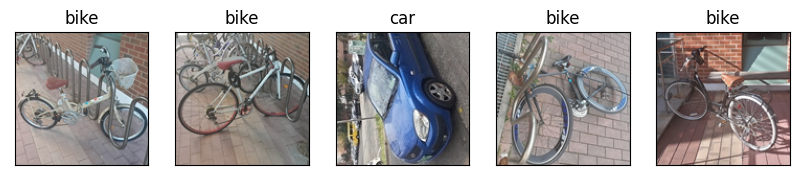

In [3]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
    image = image / 2 + 0.5 #unnormalize
    return image

#무작위로 이미지 선택
dataiter = iter(trainloader)
images, labels = next(dataiter)

#선택된 이미지 출력
fig = plt.figure(figsize = (10,5))
for i in np.arange(batch_size):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i].item()])

In [4]:
#input=128, color=3(RGB)
#conv1 = 5*5 filter >>> -4px (filter-1)
#pool1 = 4*4 >>> /4px
#conv2 = 4*4 filter >>> -3px
#pool2 = 4*4 >>> /4px
#fc1 = ((128 - 4) / 4 - 3) / 4 = 7*7

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #colorchannel, feature, filter, stride 순서로 입력
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        #feature, feature2, filter, stride
        self.conv2 = nn.Conv2d(20, 50, 4, 1)
        #fc1^2*feature2, feature3
        self.fc1 = nn.Linear(7*7*50, 500)
        #과적합 방지용
        self.dropout1 = nn.Dropout(0.5)
        #feature3, class_num
        self.fc2 = nn.Linear(500, class_num)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pool1
        x = F.max_pool2d(x, 4, 4)
        x = F.relu(self.conv2(x))
        #pool2
        x = F.max_pool2d(x, 4, 4)
        #flatten: -1, fc1^2*feature2
        x = x.view(-1, 7*7*50)
        #activation function
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [5]:
net = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(4):    #반복 횟수 설정
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        #Gradient 0으로
        optimizer.zero_grad()

        #순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #학습 진행상황 출력
        running_loss += loss.item()
        print('[epoch: %d, batch: %3d] loss: %.5f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('학습 완료')

[epoch: 1, batch:   1] loss: 0.00034
[epoch: 1, batch:   2] loss: 0.00033
[epoch: 1, batch:   3] loss: 0.00037
[epoch: 1, batch:   4] loss: 0.00075
[epoch: 1, batch:   5] loss: 0.00032
[epoch: 1, batch:   6] loss: 0.00034
[epoch: 1, batch:   7] loss: 0.00032
[epoch: 1, batch:   8] loss: 0.00029
[epoch: 2, batch:   1] loss: 0.00030
[epoch: 2, batch:   2] loss: 0.00028
[epoch: 2, batch:   3] loss: 0.00034
[epoch: 2, batch:   4] loss: 0.00034
[epoch: 2, batch:   5] loss: 0.00024
[epoch: 2, batch:   6] loss: 0.00021
[epoch: 2, batch:   7] loss: 0.00015
[epoch: 2, batch:   8] loss: 0.00014
[epoch: 3, batch:   1] loss: 0.00015
[epoch: 3, batch:   2] loss: 0.00002
[epoch: 3, batch:   3] loss: 0.00011
[epoch: 3, batch:   4] loss: 0.00010
[epoch: 3, batch:   5] loss: 0.00001
[epoch: 3, batch:   6] loss: 0.00002
[epoch: 3, batch:   7] loss: 0.00003
[epoch: 3, batch:   8] loss: 0.00065
[epoch: 4, batch:   1] loss: 0.00000
[epoch: 4, batch:   2] loss: 0.00002
[epoch: 4, batch:   3] loss: 0.00025
[

 bike 분류 정확도: 100 %
  car 분류 정확도:  75 %


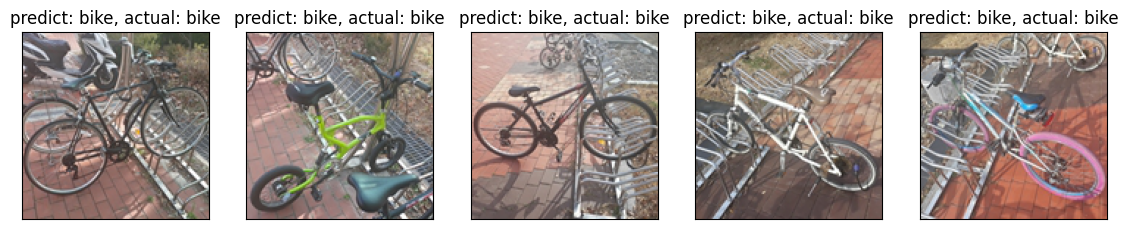

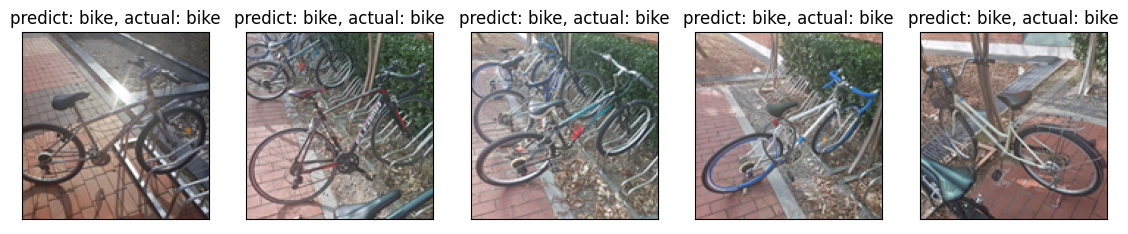

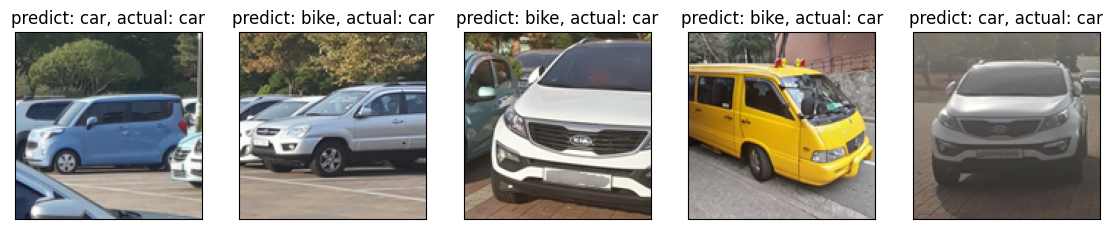

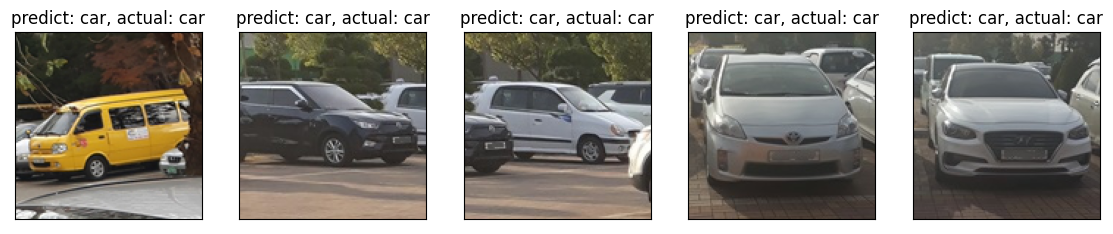

In [6]:
class_correct = list(0. for i in range(class_num))
class_total = list(0. for i in range(class_num))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        names = []
        for j in range(batch_size):
            names.append(classes[predicted[j]])

        #testset 이미지 출력
        fig = plt.figure(figsize = (14,5))
        for i in np.arange(batch_size):
            ax = fig.add_subplot(1, batch_size, i+1, xticks=[], yticks=[])
            plt.imshow(im_convert(images[i]))
            #title 설정. 예측값과 실제값 순
            title = ('predict: ' + names[i] + ', actual: ' + classes[labels[i].item()])
            ax.set_title(title)
        
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(class_num):
    print('%5s 분류 정확도: %3d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))